# Entendimiento de los datos con PySpark - Vuelos

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, sum
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [3]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [5]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\estudiante\AppData\Local\Temp\ipykernel_1068\1218200805.py:5 

In [6]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_36_202314'
db_psswd = 'aabb1122'

PATH='./'

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [7]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [11]:
sql_vuelos = 'ProyectoTransaccional.vuelosCopia2'

In [10]:
sql_detallesproyecciones = '''(SELECT 
    ano,
    mes,
    origen,
    destino,
    tipo_equipo,
    tipo_vuelo,
    trafico,
    empresa,
    vuelos,
    sillas,
    carga_ofrecida,
    pasajeros,
    carga_bordo
        FROM'ProyectoTransaccional.vuelosCopia2) AS Compatible'''

In [93]:
#Se cargan los dataframes desde la base de datos
vuelos = obtener_dataframe_de_bd(db_connection_string, sql_vuelos, db_user, db_psswd)


### Entendimiento general de datos

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [13]:
vuelos.show(5)

+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
| ano|mes|origen|destino|tipo_equipo|tipo_vuelo|trafico| empresa|vuelos|sillas|carga_ofrecida|pasajeros|carga_bordo|
+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
|2004|  1|   bog|    mia|       B752|         R|      I|AMERICAN|     0|     0|           0.0|        0|        0.0|
|2004|  7|   bog|    mia|       B752|         R|      I|AMERICAN|    62| 11656|      327236.0|     7864|   118443.0|
|2004|  9|   bog|    mia|       B752|         R|      I|AMERICAN|    32|  6016|      168896.0|     4283|    73896.0|
|2004|  3|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     3473|   203724.0|
|2004|  7|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     4994|   219965.0|
+----+---+------+-------+-----------+----------+-------+--------

In [14]:
vuelos.schema

StructType(List(StructField(ano,IntegerType,true),StructField(mes,StringType,true),StructField(origen,StringType,true),StructField(destino,StringType,true),StructField(tipo_equipo,StringType,true),StructField(tipo_vuelo,StringType,true),StructField(trafico,StringType,true),StructField(empresa,StringType,true),StructField(vuelos,IntegerType,true),StructField(sillas,IntegerType,true),StructField(carga_ofrecida,DoubleType,true),StructField(pasajeros,IntegerType,true),StructField(carga_bordo,DoubleType,true)))

Queremos entender la estructura general de los datos que se nos presentan en la tabla vuelos. Un **Análisis Temporal** con el año y el mes. **Información de Vuelos** si juntamos origen, destino y tipo_equipo. La **Información de Operaciones de Vuelo** con las columnas tipo_vuelo y trafico. La **Aerolínea** con el campo Empresa. Y, finalmente, **Métricas de Rendimiento**: vuelos, sillas, carga_ofrecida, pasajeros, carga_bordo: Estas columnas proporcionan métricas clave para evaluar el rendimiento de los vuelos, la ocupación de los asientos, la carga transportada y la eficiencia operativa.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [15]:
print((vuelos.count(), len(vuelos.columns)))

(467990, 13)


**¿Cuantos datos nos compartieron para el proyecto?**
Hay información de 605.448 vuelos entre 2004 y 2018

### Revisión de reglas de negocio 

La empresa nos da la informacion de dos hechos que verificamos a continuacion:
- La información de que hay 605.448 vuelos entre 2004 y 2018 es falsa, en total hay 4727442 vuelos.
- Solo tenemos informacion de vuelos hasta 2014

In [61]:
# Total vuelos entre 2004 y 2018
vuelos = vuelos.withColumn("ano", vuelos["ano"].cast("int"))

# Filtra los registros por el rango de años y luego calcula la suma de la columna "vuelos"
total_vuelos = vuelos.filter((col("ano") >= 2004) & (col("ano") <= 2018)).select(sum("vuelos").alias("total_de_vuelos"))

# Muestra el resultado
total_vuelos.show()

+---------------+
|total_de_vuelos|
+---------------+
|        4727442|
+---------------+



Queremos cerciorarse de la cantidad de vuelos que ocurrieron entre estos años

In [60]:
# Filtramos por año, agrupamos por año y sumamos la cantidad de vuelos.
vuelos_filtrados = vuelos.filter((col("ano") >= 2004) & (col("ano") <= 2018))
cantidad_vuelos_por_anio = vuelos_filtrados.groupBy("ano").agg(count("*").alias("cantidad_de_vuelos")).orderBy("ano")

# Muestra el resultado
cantidad_vuelos_por_anio.show()

+----+------------------+
| ano|cantidad_de_vuelos|
+----+------------------+
|2004|             38869|
|2005|             44842|
|2006|             48097|
|2007|             47501|
|2008|             42530|
|2009|             33156|
|2010|             37196|
|2011|             40525|
|2012|             43324|
|2013|             46561|
|2014|             45389|
+----+------------------+



### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [64]:
vuelos.summary().show()

+-------+------------------+------------------+------+-------+------------------+----------+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|               ano|               mes|origen|destino|       tipo_equipo|tipo_vuelo|trafico|           empresa|            vuelos|           sillas|   carga_ofrecida|         pasajeros|       carga_bordo|
+-------+------------------+------------------+------+-------+------------------+----------+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  count|            467990|            467990|115441| 115441|            467990|    467990| 467990|            467990|            467990|           467990|           467987|            467990|            467971|
|   mean|2009.0125451398535|6.5515397665929775|  null|   null| 627.5512585591667|      null|   null|              null|10.101587640761554|723.759932

{'whiskers': [<matplotlib.lines.Line2D at 0x1603270f688>,
 'caps': [<matplotlib.lines.Line2D at 0x1603270f388>,
 'boxes': [<matplotlib.lines.Line2D at 0x160323a7848>],
 'medians': [<matplotlib.lines.Line2D at 0x160339fdd88>],
 'fliers': [<matplotlib.lines.Line2D at 0x16028521d48>],
 'means': []}

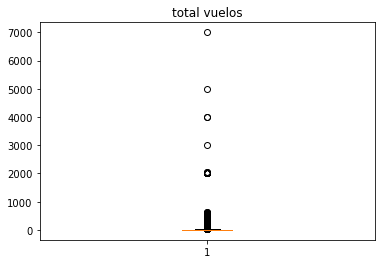

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('total vuelos')
ax1.boxplot(np.array(vuelos.select('vuelos').collect()))

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. Queremos mostrar la distribucion de registros por año:

In [71]:
vuelos.groupby("ano").count().orderBy("count", ascending=False).show(20)

+----+-----+
| ano|count|
+----+-----+
|2006|48097|
|2007|47501|
|2013|46561|
|2014|45389|
|2005|44842|
|2012|43324|
|2008|42530|
|2011|40525|
|2004|38869|
|2010|37196|
|2009|33156|
+----+-----+



## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [72]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [75]:
columnas_vacias_vuelos = contar_vacios(vuelos)
columnas_vacias_vuelos

número de vacíos para columna origen: 352549
número de vacíos para columna destino: 352549
número de vacíos para columna carga_ofrecida: 3
número de vacíos para columna carga_bordo: 19


[352549, 352549, 3, 19]

In [77]:
columnas_alta_cardinalidad_vuelos = cardinalidad(vuelos)
columnas_alta_cardinalidad_vuelos

{}

### Consistencia
Vamos a revisar el nivel de consistencia en la variable vuelos.

In [78]:
#consistencia: revisar genially: definicion de consistencia
ids_vuelos = set([x.vuelos for x in vuelos.select('vuelos').collect()])
len(ids_vuelos)

518

## Herramientas para facilitar el entendimiento de datos

Algunas de las estadísticas antes desarrolladas pueden obtenerse por medio de herramientas como Pandas Profiling una herramienta muy útil, <b><i>Pero no perfecta ni completa</i></b>, es Pandas profiling que dado un conjunto de datos, nos muestra histogramas, estadísticas etc. A continuación guardamos el reporte en html

In [79]:
reporte = ProfileReport(vuelos.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Summarize dataset:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 16/24 [00:08<00:03,  2.43it/s, Calculate kendall correlation]C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


<b>Cabe aclarar que un pandas profiling sin interpretación no es suficiente como análisis para realizar el entendimiento de los datos.

Así mismo, recuerde que si es necesario, se debe utilizar otra herramienta (código, visualizaciones, etc) para poder completar el análisis estadístico.</b>

### Algunas gráficas utiles: Diagrama de caja, dispersion, histogramas para entender las distribuciones de las variables

Generalmente las gráficas se emplean para entender la distribución de cada variable, también sirven para visualizar la relación entre 2 o más variables

Algunas gráficas útiles son los histogramas, disepersión, diagramas de caja. Hay varias maneras de implementarlos, con paquetes como matplotlib o pandas, con funciones propias de pyspark, etc, a continuacón mostramos cómo hacerlo a travez de pandas

array([[<AxesSubplot:title={'center':'ano'}>]], dtype=object)

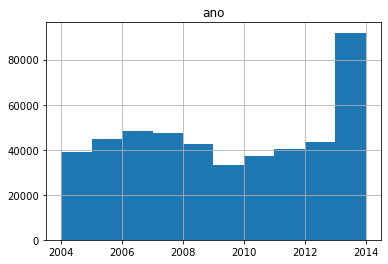

In [83]:
#para valores extremos(subir a calidad)
vuelos.toPandas().hist(column='ano')

In [92]:
cantidades = vuelos.groupby("ano").count().orderBy("count", ascending=False)

Como se puede observar, el método retorna un dataframe, que vamos a usar para obtener dos arreglos, uno con el rango de cada una de las barras y otro con la cantidad de registros por rango. Se puede usar Matplotlib para graficar esta información:

In [87]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

plotHistogramData(cantidades)

TypeError: type str doesn't define __round__ method

El diagrama de dispersion, nos muestra los datos para dos variables en forma de puntos y es muy útil para entender la relación entre dichas variables

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>Fecha_de_pedido</i> y por cada <i>ID_de_vendedor</i>, es decir por fecha y por empleado cuantas ordenes existen:

In [88]:
vuelos.groupBy('ano').pivot('vuelos').count().show()

+----+----+-----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+----+---+----+----+---+---+---+---+----+---+---+---+----+----+----+----+---+----+----+----+----+---+----+---+---+----+----+----+----+----+----+----+----+----+----+----+---+----+----+---+----+---+----+---+----+----+----+----+----+----+----+----+----+---+----+----+---+----+----+----+----+---+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----

Otro análisis muy útil es el de la correlación lineal entre dos variables, para ver la matriz de correlacion que mide esta dependencia o la fuerza de la relación lineal entre dos variables vamos a usar pandas, la interpretación es que si entre dos variables A y B  el valor obtenido es cercano a -1 o a 1, se interpreta como que A y B contienen la misma información y por ende no es necesario mantener ambas columnas

In [89]:
corr = vuelos.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,ano,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo
ano,1.000000,0.043146,0.049414,0.011675,0.036868,0.007143
vuelos,0.043146,1.000000,0.579593,0.161394,0.361625,0.084908
sillas,0.049414,0.579593,1.000000,0.346184,0.442185,0.038188
carga_ofrecida,0.011675,0.161394,0.346184,1.000000,0.169790,0.297126
pasajeros,0.036868,0.361625,0.442185,0.169790,1.000000,0.146371
carga_bordo,0.007143,0.084908,0.038188,0.297126,0.146371,1.000000


## Conclusiones/resultados

## Tabla vuelosCopia2

## 1. **Completitud de los datos:**

> ### 1.1 **Cantidad de registros y cantidad de columnas por tipo de dato:**

 
> Como se puede ver en la imagen anterior se logra generar el esquema de un DataFrame de la tabla VuelosCopia2 el cual incluye los nombres de las columnas así como el tipo de dato de cada una de ellas. 

## 3. **Conclusión:**

> ### 3.1 **Análisis basado en tableros:**
Yo diria que si se puede hacer analisis basado en tableros dado la informacion es veraz, unificada y valida. Sin embargo  hay que identificar el propsito de la tabla según las demas tablas.
> 

> ### 3.2 **Fila Promedio:**
Se refiere al tamaño promedio de una fila en esa tabla. Esto es importante para entender el uso de espacio y la eficiencia de almacenamiento en una base de datos. El tamaño de una fila en una tabla puede variar dependiendo de los tipos de datos de las columnas y la cantidad de datos almacenados en cada fila.

> ### 3.3. Solución de Preguntas:
- Se mencionan en parrafos superiores. 

> ### 3.4. Dudas o Supuestos:
- No se puede identificar la hora en la que ocurre un viaje, ni tampoco el genero de los pasajeros. 
- En el rango de fechas que habla el negocio hace falta informacion de al menos 4 años.
- Informacion sobre costos de operacion y mantenimiento
- Precios o valores pagados por los clientes. 
Para este apartado no me queda claro está tabla como se relaciona con los vuelos y los viajes, a no ser de que sea proyeciones de los posibles clientes que se peudan tener en un año para que viajen en avion.
